In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path=r'D:/模式识别/自我监测系统项目/TestData.xml'

In [3]:
tree=ET.parse(path)
root=tree.getroot()

In [4]:
df=pd.DataFrame([list.attrib for list in root.findall('Record')])

In [5]:
print(f"表格大小{df.shape}")
print(f"列名{df.columns}")
print(f"行名{df.index}")
print(f"type:{df['type'].unique()}")

表格大小(20520, 9)
列名Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')
行名RangeIndex(start=0, stop=20520, step=1)
type:['HKQuantityTypeIdentifierHeight' 'HKQuantityTypeIdentifierBodyMass'
 'HKQuantityTypeIdentifierHeartRate'
 'HKQuantityTypeIdentifierOxygenSaturation'
 'HKQuantityTypeIdentifierRespiratoryRate'
 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierAppleExerciseTime'
 'HKQuantityTypeIdentifierRestingHeartRate'
 'HKQuantityTypeIdentifierWalkingHeartRateAverage'
 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage'
 'HKQuantityTypeIdentifierAppleStandTime'
 'HKQuantityTypeIdentifierWalkingSpe

In [6]:
#将由xml转成Dataframe的value列里面原本是字符串格式转换为python对象(python能识别为时间的东西）
df['startDate']=pd.to_datetime(df['startDate'])
df['endDate']=pd.to_datetime(df['endDate'])
#切出我有用备忘录记录下来当前状态的时间段
start_time=pd.to_datetime('2026-02-08 00:38:00+0800')
end_time = pd.to_datetime('2026-02-09 15:20:00+0800')
mask=(df['startDate']>=start_time)&(df['endDate']<=end_time)
RecordDF=df.loc[mask].copy()

#把value列从字符串转为数字,第二个参数意思为遇到转不动的就变为空局NaN
RecordDF['value']=pd.to_numeric(RecordDF['value'],errors='coerce')

# 顺手删掉转换后产生的空值，保证绘图连续性
RecordDF = RecordDF.dropna(subset=['value'])

#选择要观察的信号列表
target_signals={
    'HRV': 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
    'HR': 'HKQuantityTypeIdentifierHeartRate',
    'Respiratory': 'HKQuantityTypeIdentifierRespiratoryRate',
    'Oxygen': 'HKQuantityTypeIdentifierOxygenSaturation',
    'Audio': 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
}
print(f"切出成功")

切出成功


In [7]:
#Test
# 看看整张大表里，最早和最晚的一条记录分别是什么时候（确定没有传感器记录问题）
print("数据文件中实际包含的时间范围：")
print(f"起点: {df['startDate'].min()}")
print(f"终点: {df['startDate'].max()}")

数据文件中实际包含的时间范围：
起点: 2025-10-15 12:00:00+08:00
终点: 2026-02-10 16:29:49+08:00


In [8]:
#时区转换
import pandas as pd

# 1. 彻底重新处理时间（确保干净）
df['startDate'] = pd.to_datetime(df['startDate'], utc=True).dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

# 2. 设置窗口
start_time = pd.to_datetime('2026-02-08 00:38:00')
end_time = pd.to_datetime('2026-02-09 15:20:00')

# 3. 优化后的筛选：只管开始时间在范围内就行
# 这样能防止因为 endDate 稍微超了一点点就被整行排除的情况
mask = (df['startDate'] >= start_time) & (df['startDate'] <= end_time)

# 4. 生成结果
RecordDF = df.loc[mask].copy()

#转换成数字
RecordDF['value'] = pd.to_numeric(RecordDF['value'], errors='coerce')
RecordDF = RecordDF.dropna(subset=['value'])

print(f"目标区间筛选出的行数: {len(RecordDF)}")
if not RecordDF.empty:
    print(f"筛选后的实际终点: {RecordDF['startDate'].max()}")

目标区间筛选出的行数: 1207
筛选后的实际终点: 2026-02-09 14:30:58


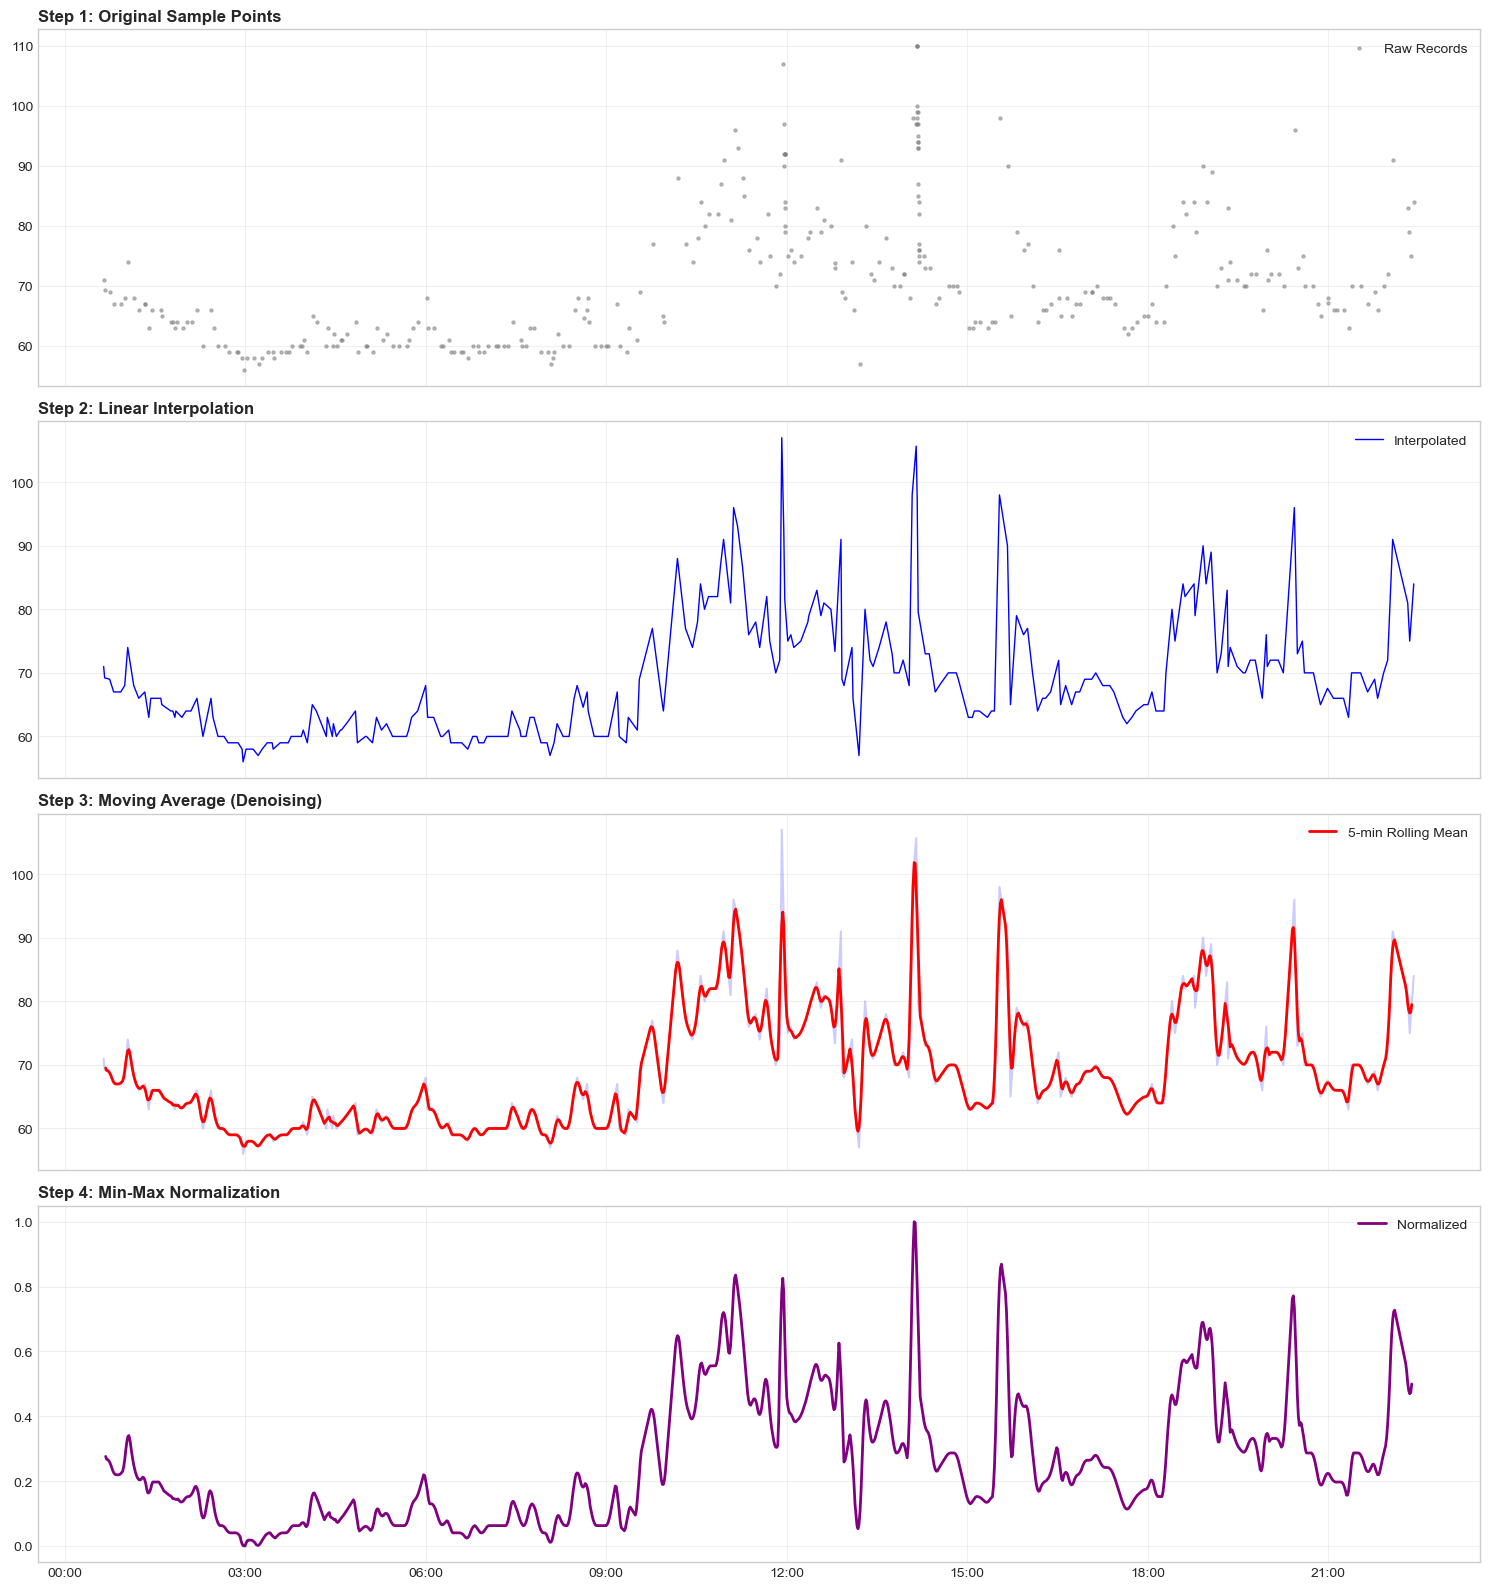

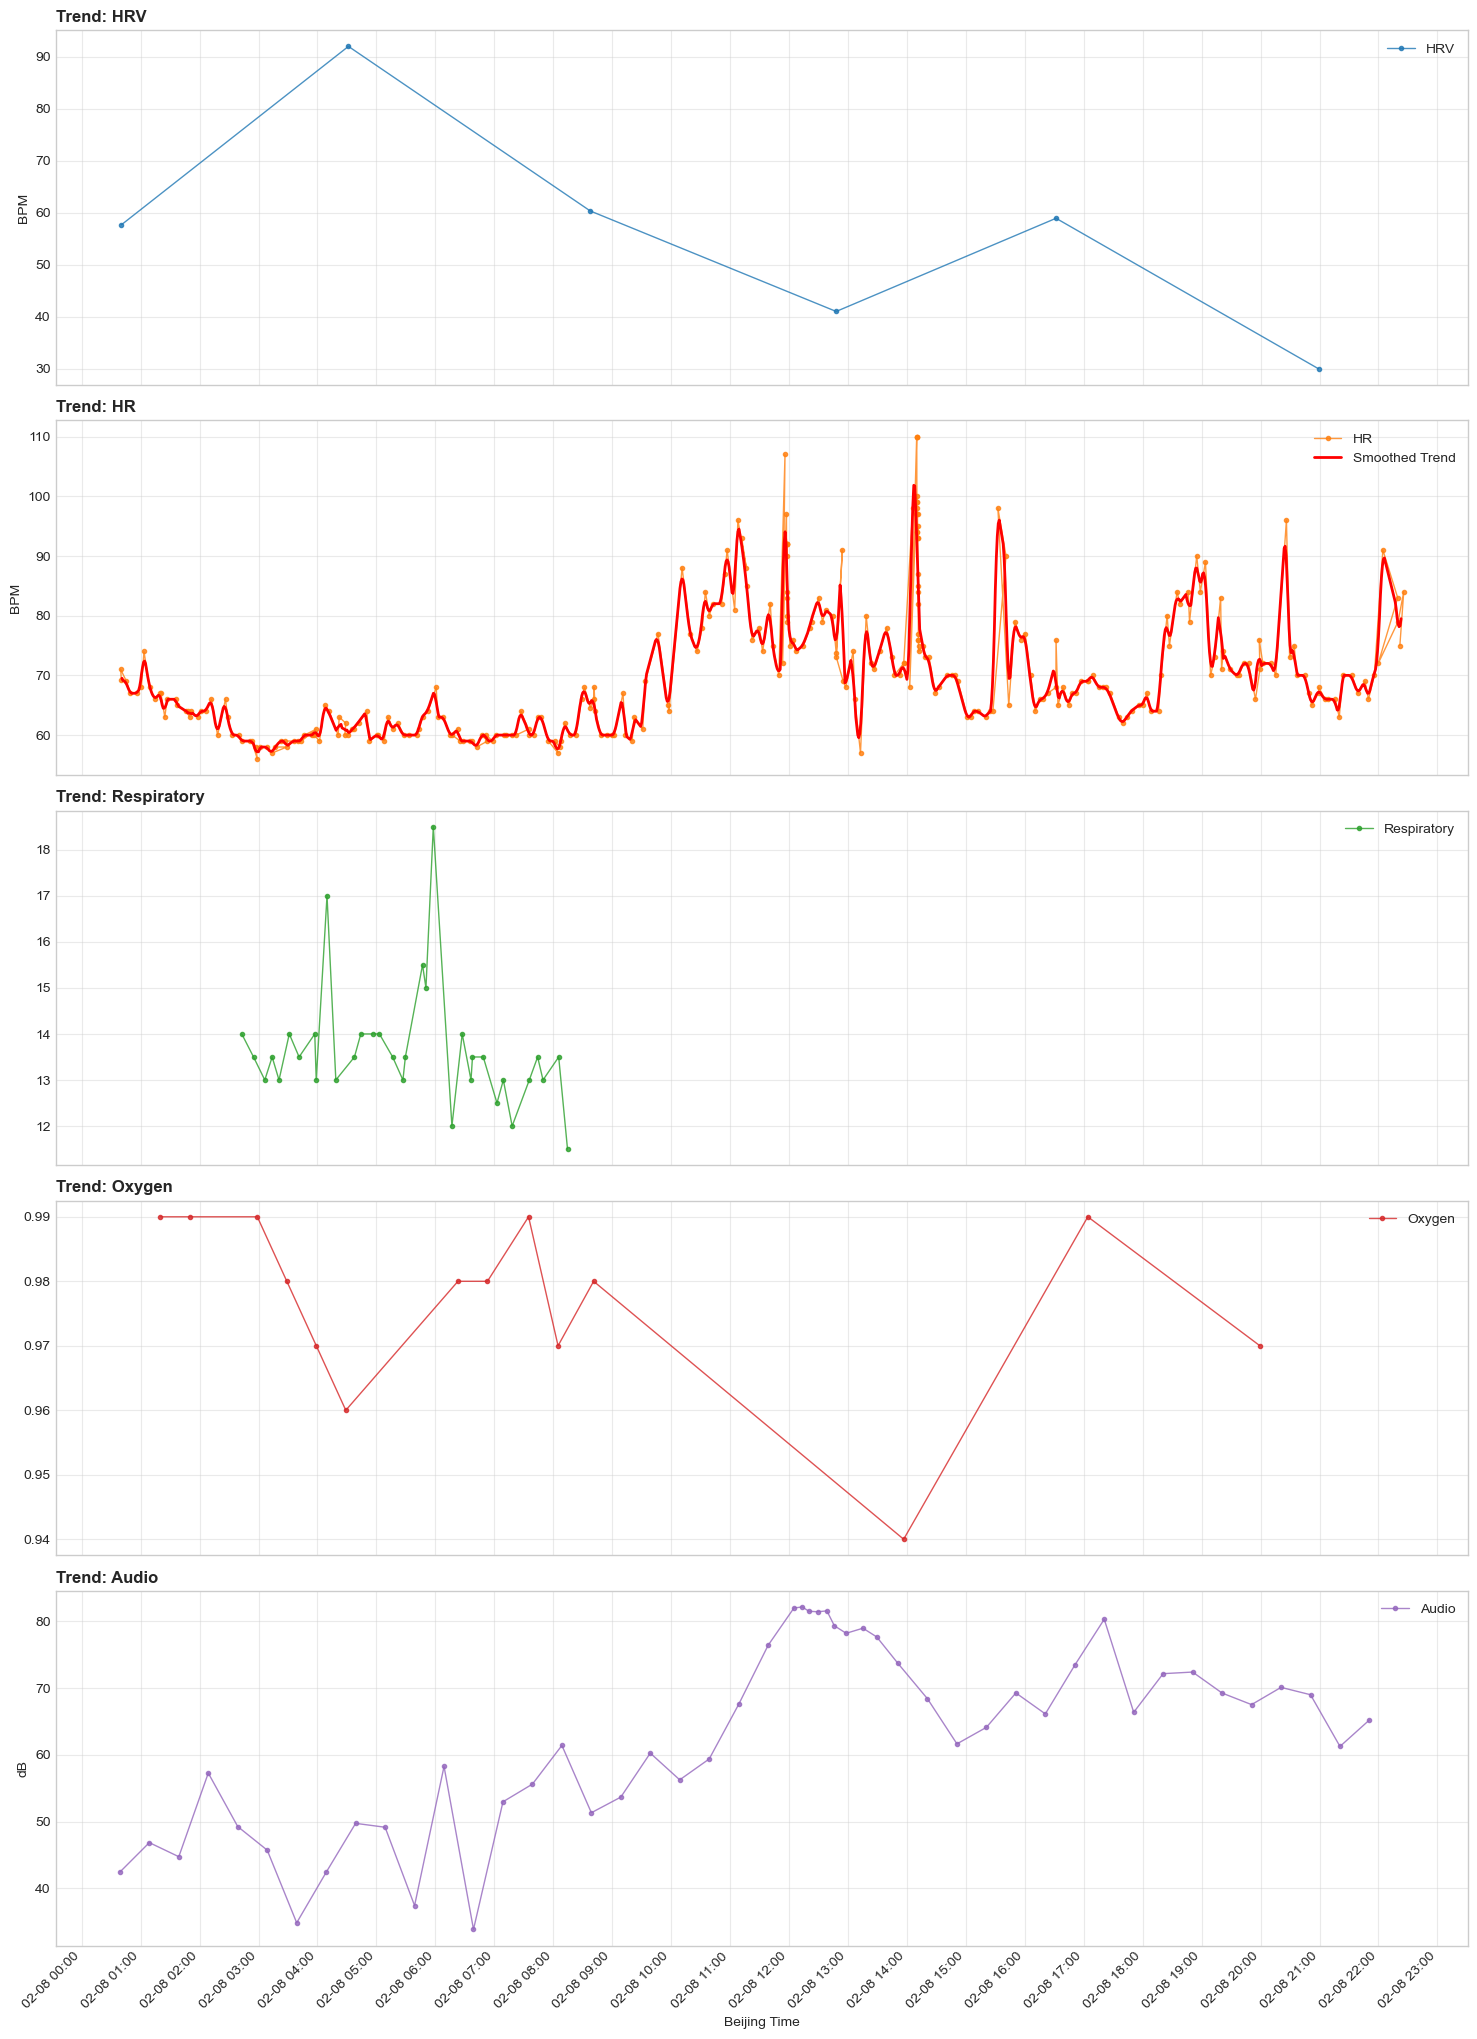

In [9]:
#画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')

# 2. 确定有哪些信号在数据中是真实存在的
available_signals = {
    label: iden for label, iden in target_signals.items() 
    if not RecordDF[RecordDF['type'] == iden].empty
}

num_charts = len(available_signals)

if num_charts == 0:
    print("当前筛选的时间范围内没有找到匹配的信号数据。")
else:
    # ==========================================
    # 第一部分：专门针对 HR 的深度处理与流水线可视化
    # ==========================================
    if 'HR' in available_signals:
        # 提取原始数据 (解决 NameError 的关键)
        hr_raw = RecordDF[RecordDF['type'] == target_signals['HR']].copy()
        
        # 1. 异常值处理
        hr_cleaned = hr_raw[(hr_raw['value'] > 40) & (hr_raw['value'] < 180)].copy()
        
        # 2. 准备插值 (设置索引)
        hr_cleaned = hr_cleaned.set_index('startDate').sort_index()
        
        # 3. 重新采样与插值 (将 '1T' 改为 '1min' 消除警告)
        hr_interp = hr_cleaned['value'].resample('1min').mean().interpolate(method='linear')
        
        # 4. 移动平均 (平滑)
        hr_smooth = hr_interp.rolling(window=5, center=True).mean()
        
        # 5. 归一化
        hr_norm = (hr_smooth - hr_smooth.min()) / (hr_smooth.max() - hr_smooth.min())

        # --- 弹窗显示 HR 处理全过程 ---
        fig_step, axes_step = plt.subplots(4, 1, figsize=(15, 16), sharex=True)
        
        # 子图 0: 原始数据
        axes_step[0].scatter(hr_raw['startDate'], hr_raw['value'], color='gray', s=5, alpha=0.5, label='Raw Records')
        axes_step[0].set_title("Step 1: Original Sample Points", loc='left', fontweight='bold')
        
        # 子图 1: 线性插值
        axes_step[1].plot(hr_interp.index, hr_interp.values, color='blue', linewidth=1, label='Interpolated')
        axes_step[1].set_title("Step 2: Linear Interpolation", loc='left', fontweight='bold')
        
        # 子图 2: 移动平均
        axes_step[2].plot(hr_interp.index, hr_interp.values, color='blue', alpha=0.2)
        axes_step[2].plot(hr_smooth.index, hr_smooth.values, color='red', linewidth=2, label='5-min Rolling Mean')
        axes_step[2].set_title("Step 3: Moving Average (Denoising)", loc='left', fontweight='bold')
        
        # 子图 3: 归一化
        axes_step[3].plot(hr_norm.index, hr_norm.values, color='purple', linewidth=2, label='Normalized')
        axes_step[3].set_title("Step 4: Min-Max Normalization", loc='left', fontweight='bold')
        
        for ax_s in axes_step:
            ax_s.legend(loc='upper right')
            ax_s.grid(True, alpha=0.3)
            ax_s.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        plt.tight_layout()
        plt.show() # 先展示这个过程，关闭后再出总图
    
    # ==========================================
    # 第二部分：绘制所有指标的总趋势图
    # ==========================================
    fig, axes = plt.subplots(num_charts, 1, figsize=(15, 4 * num_charts), sharex=True)
    if num_charts == 1: axes = [axes]

    for i, (label, identifier) in enumerate(available_signals.items()):
        ax = axes[i]
        subset = RecordDF[RecordDF['type'] == identifier].copy()
        
        # 绘图逻辑
        ax.plot(subset['startDate'], subset['value'], 'o-', 
                markersize=3, linewidth=1, label=label, color=f'C{i}', alpha=0.8)
        
        # 针对 HR 的特殊增强：在总图上叠加平滑后的红色曲线（高水平体现）
        if label == 'HR':
            ax.plot(hr_smooth.index, hr_smooth.values, color='red', linewidth=2, label='Smoothed Trend')

        # 样式美化
        ax.grid(True, which='major', linestyle='-', alpha=0.4)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.set_title(f'Trend: {label}', fontsize=12, loc='left', fontweight='bold')
        ax.legend(loc='upper right')
        
        # 单位设置
        if 'HeartRate' in identifier: ax.set_ylabel('BPM')
        elif 'Variability' in identifier: ax.set_ylabel('ms (SDNN)')
        elif 'Audio' in identifier: ax.set_ylabel('dB')

    
    plt.xlabel('Beijing Time')
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

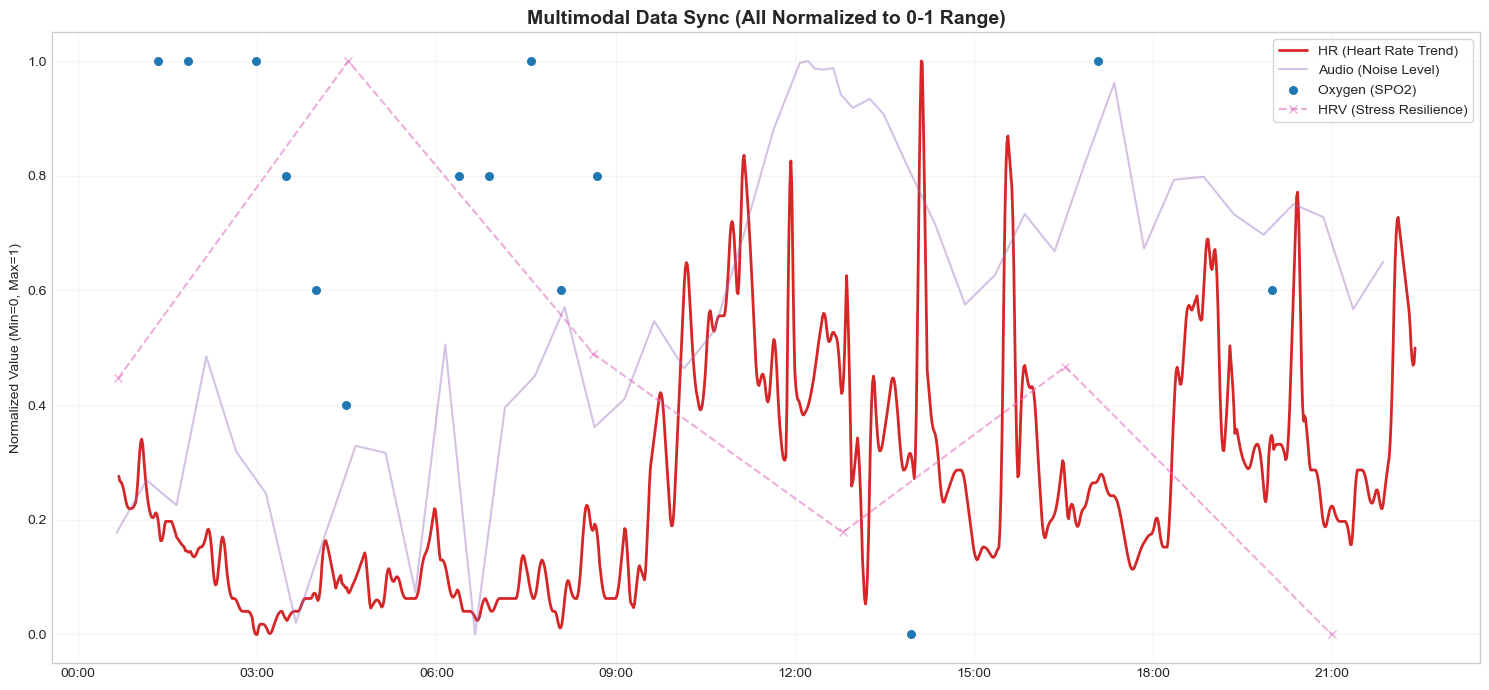

In [13]:
#归一化和结论展示
# ==========================================
# 第三部分：多指标一图对齐 (Normalized Overlay)
# ==========================================

# 定义归一化函数：把 60~110 映射到 0~1
def norm_data(s):
    return (s - s.min()) / (s.max() - s.min())

plt.figure(figsize=(15, 7))

# 1. 画心率 (使用你处理好的平滑曲线)
plt.plot(hr_norm.index, hr_norm.values, label='HR (Heart Rate Trend)', color='#d62728', linewidth=2)

# 2. 画环境音 (如果存在)
if 'Audio' in available_signals:
    audio_df = RecordDF[RecordDF['type'] == target_signals['Audio']].copy()
    # 归一化并绘图
    plt.plot(audio_df['startDate'], norm_data(audio_df['value']), 
             label='Audio (Noise Level)', color='#9467bd', alpha=0.4)

# 3. 画血氧 (如果存在，用点表示，因为太稀疏)
if 'Oxygen' in available_signals:
    ox_df = RecordDF[RecordDF['type'] == target_signals['Oxygen']].copy()
    plt.scatter(ox_df['startDate'], norm_data(ox_df['value']), 
                label='Oxygen (SPO2)', color='#1f77b4', s=30, zorder=5)

# 4. 画 HRV (如果存在)
if 'HRV' in available_signals:
    hrv_df = RecordDF[RecordDF['type'] == target_signals['HRV']].copy()
    plt.plot(hrv_df['startDate'], norm_data(hrv_df['value']), 
             label='HRV (Stress Resilience)', color='#e377c2', marker='x', linestyle='--', alpha=0.6)

# 图表美化
plt.title("Multimodal Data Sync (All Normalized to 0-1 Range)", fontsize=14, fontweight='bold')
plt.ylabel("Normalized Value (Min=0, Max=1)")
plt.legend(loc='upper right', frameon=True)
plt.grid(True, alpha=0.2)

# 设置横坐标时间格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=0)

plt.tight_layout()


plt.show()